In [1]:
import os
import time
import itertools

from torchvision.transforms import v2
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# from PIL import Image
from tqdm import tqdm
# import mediapy as media

%load_ext autoreload
%autoreload 2
from vae_model import *
from ph_dataset import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# torchvision.disable_beta_transforms_warning()

/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <38796DC6-8F33-3A89-BBAA-5FC71F99817A> /Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/nico/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints a

In [2]:
# Training helper functions
def make_training_loss_plot(log_dict, figsize=(9,6)):
    """Plot training loss vs step"""
    epoch = log_dict['Epoch'][-1]
    log_df = pd.DataFrame.from_dict(log_dict)
    plt.figure(figsize=figsize)
    sns.lineplot(
        log_df,
        x='Step',
        y='Loss',
        errorbar=None,
    )
    ax = plt.gca()
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.title(f'Training Loss After {epoch} Epochs')
    plt.show()

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    if verbose: print(f"Using device {device}")
    return device

def show_dataset_sample(dataset, nrows=5, ncols=15):
    nsamples = nrows * ncols
    idxs = np.arange(len(dataset))
    sample_idxs = np.random.choice(idxs, nsamples, replace=False)
    
    if len(sample_idxs) < nsamples:
        print('Not enough training data')

    f = plt.figure(figsize=(ncols*1.2, nrows*2))
    f.tight_layout()

    canvas = np.zeros((nrows * 16, ncols * 16))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        ph_data = ph_dataset.get_ph_data(idx)
        ph_img_clean = ph_data['img']
        max_pixel_val = ph_data['max_pixel_val']
        meta = ph_data['meta']
        canvas[row*16:(row+1)*16, col*16:(col+1)*16] = ph_img_clean

    img_plt = plt.imshow(canvas * max_pixel_val, cmap='rocket')
    plt.colorbar(img_plt, fraction=0.045)
    # 
    # plt.imshow(canvas, cmap='icefire')
    plt.title("Pulse Height Dataset Sample")
    plt.show(f)
    plt.close(f)

In [3]:
# Forward method
def vae_forward(
    vae: VaeModel16x16,
    X: torch.Tensor,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        X: (N, C, 16, 16) input tensor of Cx16x16 images

    Returns:
        (,) vae loss.
    """
    # Apply positional encoding to input coordinates
    vae.train()
    recon_x, mu, logvar = vae.forward(X)
    return vae_loss(recon_x, X, mu, logvar)

# Sampling method
@torch.inference_mode()
def vae_sample(
    vae: VaeModel16x16,
    nsamples: int,
    img_cwh: tuple[int, int],
    seed: int,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        nsamples: number of images to create
        img_cwh: image dimensions (W, H)
    Returns:
        (,) 
    """
    vae.eval()
    device = get_device()
    with torch.no_grad():
        torch.manual_seed(seed)
        z = torch.randn(nsamples, vae.latent_dim).to(device)
        return vae.decode(z).cpu()

In [14]:
# VaeWrapper: one level of indirection to make experimentation on the fly easier

class VaeWrapper(nn.Module):
    def __init__(
        self,
        vae: VaeModel16x16,
        input_img_cwh: tuple[int, int] = (1, 16, 16),
        seed: int = 180,
    ):
        super().__init__(),
        self.vae = vae
        self.img_cwh = input_img_cwh
        self.seed = seed
        
    def forward(self, X: torch.Tensor):
        """
        Args:
            X: (N, C, 16, 16) input tensor of C x 16 x 16 images

        Returns:
            (,) VAE loss.
        """
        self.vae.train()
        assert X[0].shape == torch.Size(self.img_cwh), f"X.shape={X.shape} but img_cwh={self.img_cwh}"
        return vae_forward(self.vae, X)

    @torch.inference_mode()
    def sample(
        self,
        nsamples: int = 16,
    ):
        self.vae.eval()
        return vae_sample(self.vae, nsamples, self.img_cwh, self.seed)

In [15]:
# Training function for VAE model

def train_vae(
    train_config,
    ph_dataset,
    img_cwh = (1, 16, 16),
    seed = 180,
    verbose=True,
):
    device = get_device()
    ### Create panoseti dataloader
    
    train_loader = torch.utils.data.DataLoader(
        dataset = ph_dataset,
        batch_size = train_config['batch_size'],
        shuffle=False,
    )
    if verbose:
        show_dataset_sample(ph_dataset, nrows=5, ncols=15)
    
    ### Model training config
    in_channels = img_cwh[0]
    model = VaeWrapper(
        vae = train_config['model'](
            in_channels,
            hidden_dim = train_config['hidden_dim'],
            latent_dim = train_config['latent_dim'],
        ),
        input_img_cwh = img_cwh,
        seed = seed,
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'], weight_decay=train_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=train_config['gamma'])

    ### Train Model
    log_dict = {
        'Step': [],
        'Loss': [],
        'Epoch': []
    }
    os.makedirs('vae_model_checkpoints', exist_ok=True)
    
    step = 0
    for epoch in range(1, train_config['num_epochs'] + 1):
        torch.manual_seed(seed + epoch)
        for x in tqdm(train_loader, unit="batch"):
            step += 1
            model.train()
            x = x.to(device)

            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()
    
            if step % 5 == 0: 
                log_dict['Epoch'].append(epoch)
                log_dict['Step'].append(step)
                log_dict['Loss'].append(np.abs(loss.item()))
        
        # Update learning rate
        scheduler.step()
        
        # Make figures for this Epoch
        print(f'Epoch {epoch}\n')
        if (epoch - 1) % 5 == 0: 
            plot_sample(model)
            make_training_loss_plot
        if (epoch - 1) % 20 == 0:
            # make_training_loss_plot(log_dict)
            torch.save(model, f"vae_model_checkpoints/vae2_nepoch={epoch}_ldim={train_config['latent_dim']}")

    log_df = pd.DataFrame.from_dict(log_dict)
    make_training_loss_plot(log_dict)
    plot_sample(model)
    return model, log_df

In [24]:
def plot_sample(model: VaeWrapper, nrows=5, ncols=15, size=16):
    nsamples = nrows * ncols
    sampled_images = model.sample(nsamples = nsamples)
    assert len(sampled_images) == nrows * ncols
    imgs = np.zeros((nrows * size, ncols * size))
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        
        curr = sampled_images[i, 0, ...].reshape(size, size)
        imgs[row*size:(row+1)*size, col*size:(col+1)*size] = curr.numpy()
    plt.figure(figsize=(15, 5))
    plt.imshow(imgs, cmap='rocket', vmin = 0, vmax=1)
    plt.show()

In [25]:
ph_dataset_config = {
    "data_dir": './test_data',
    "run_dir": 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd',
    "module_ids": 'all',
}

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ToDtype(torch.float),
])

ph_dataset = PulseHeightDataset(ph_dataset_config, transform=transform, log_level=logging.ERROR)

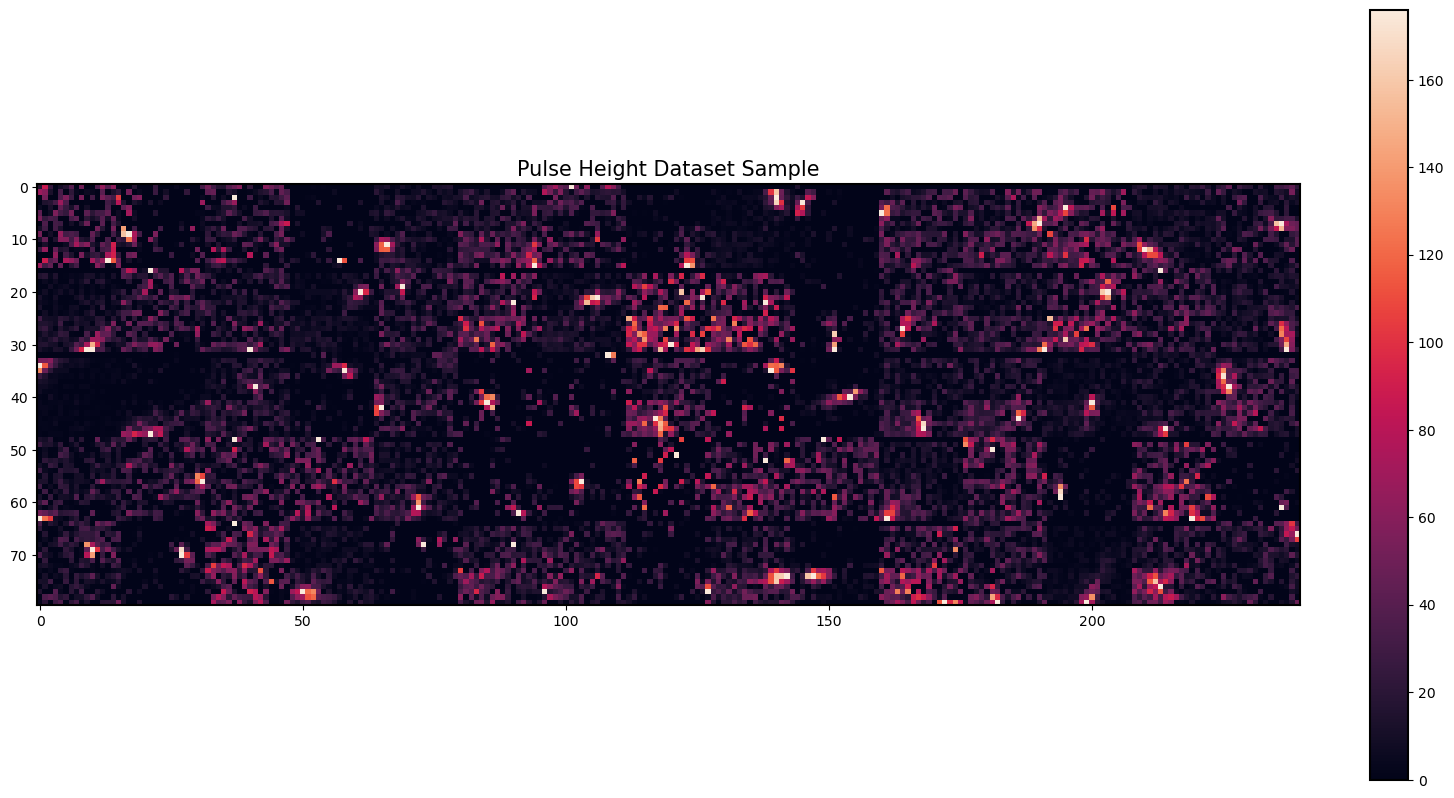

100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.11batch/s]


Epoch 1



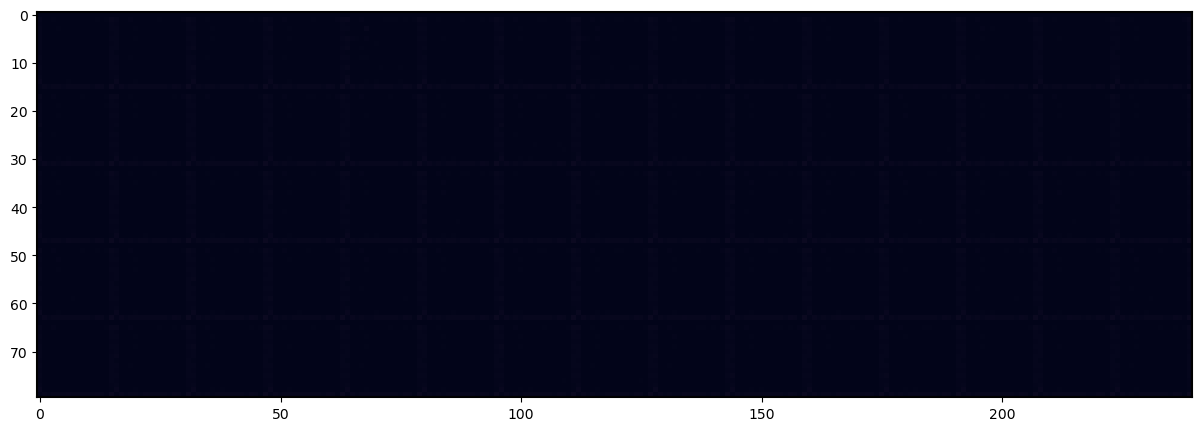

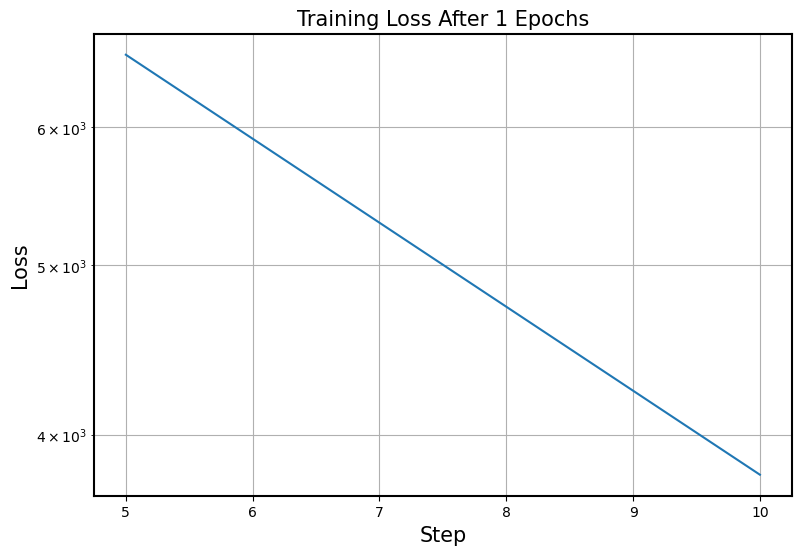

100%|████████████████████████████████████████| 11/11 [00:11<00:00,  1.06s/batch]


Epoch 2



100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.16batch/s]


Epoch 3



100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.21batch/s]


Epoch 4



100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.16batch/s]


Epoch 5



100%|████████████████████████████████████████| 11/11 [00:08<00:00,  1.23batch/s]


Epoch 6



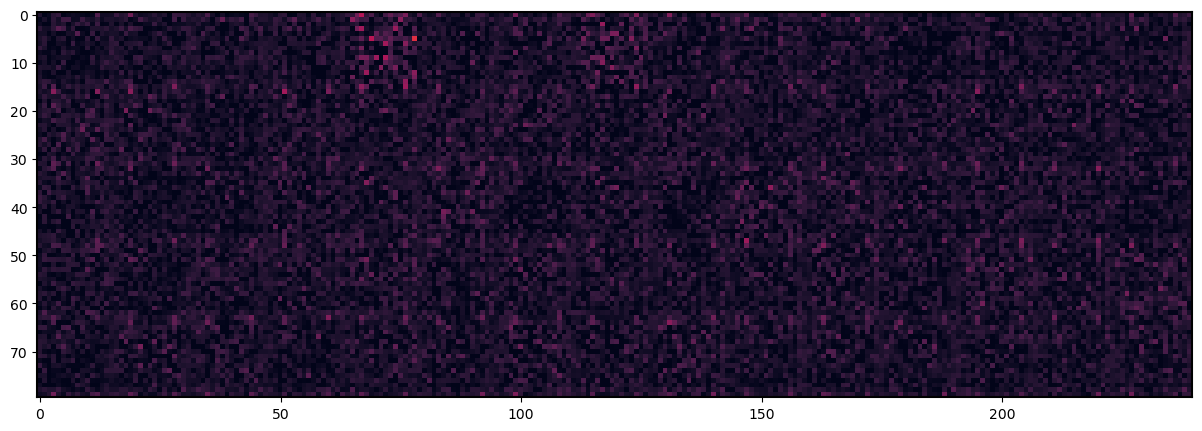

100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.20batch/s]


Epoch 7



100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.18batch/s]


Epoch 8



100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.18batch/s]


Epoch 9



100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.14batch/s]


Epoch 10



100%|████████████████████████████████████████| 11/11 [00:09<00:00,  1.13batch/s]


Epoch 11



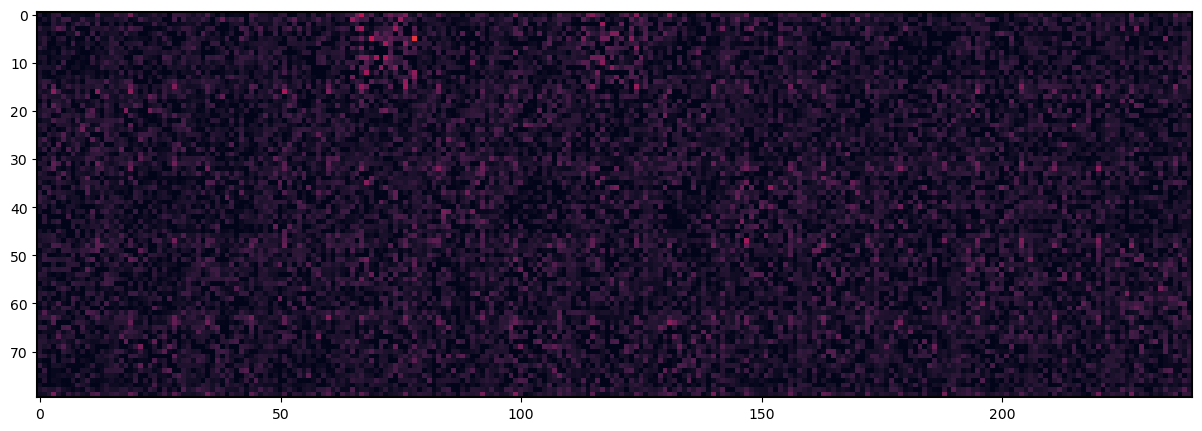

 27%|███████████▏                             | 3/11 [00:02<00:05,  1.34batch/s]

In [ ]:
train_config = {
    'model': VaeModel16x16,
    'hidden_dim': 128,
    'latent_dim': 128,
    'num_epochs': 100,
    'batch_size': 512,
    'gamma': 0.1,
    'lr': 1e-4,
    'weight_decay': 1e-9,
}

model, log_df = train_vae(
    train_config,
    ph_dataset, 
    img_cwh = (1, 16, 16),
    seed = 1820,
    verbose = True
)